In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers datasets
!pip install pytorch_lightning==0.7.5
!pip install sentencepiece

     |████████████████████████████████| 5.8 MB 29.6 MB/s 
     |████████████████████████████████| 451 kB 78.4 MB/s 
     |████████████████████████████████| 182 kB 81.7 MB/s 
     |████████████████████████████████| 7.6 MB 84.1 MB/s 
     |████████████████████████████████| 212 kB 85.6 MB/s 
     |████████████████████████████████| 132 kB 86.6 MB/s 
     |████████████████████████████████| 127 kB 106.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 233 kB 26.7 MB/s 
     |████████████████████████████████| 829 kB 75.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491071 sha256=e029ac75bca163cef306a56c11b363ce28983a535cf1caab7f5e8842d0b7c7c8
  Stored in directory: /root/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstallin

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

#from torch.optim import AdamW
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
# from transformers import logging
# logging.set_verbosity_error()  # skip warnings

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

clean = re.compile('<.*?>')
code_re = re.compile('<code>.*?<\/code>')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("pacovaldez/stackoverflow-questions-2016")

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/pacovaldez___parquet/pacovaldez--stackoverflow-questions-2016-4093bd52f522f19b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['title', 'body', 'label'],
        num_rows: 118778
    })
    test: Dataset({
        features: ['title', 'body', 'label'],
        num_rows: 118718
    })
    validation: Dataset({
        features: ['title', 'body', 'label'],
        num_rows: 59330
    })
})

In [ ]:
raw_datasets['test'][0]

{'title': 'How replace position++ code to make it Swift 3 compatible?',
 'body': "<p>I have following class, which has method <code>getNextToken</code> to iterate array items:</p>\n\n<pre><code>class Parser {\n    let tokens: [Token]\n    var position = 0\n\n    init(tokens: [Token]) {\n        self.tokens = tokens\n    }\n\n    func getNextToken() -&gt; Token? {\n        guard position &lt; tokens.count else {\n            return nil\n        }\n    return tokens[position++]\n    }\n}\n</code></pre>\n\n<p>but i have a warning message from compiler that ++ will be deprecated in Swift 3</p>\n\n<p>How should i rewrite my code to let method return array item at current position and increment position after that?</p>\n\n<p>Standard recommendations to add one more line <code>position +=1</code> doesn't fit here because i am exiting from the scope exactly when i am evaluating <code>tokens[position++]</code></p>",
 'label': 3}

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Model

In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams, model=None, tokenizer=None):
    super(T5FineTuner, self).__init__()
    # self.save_hyperparameters(params, ignore=['model', 'tokenizer'])
    if isinstance(hparams, dict):
      hparams = argparse.Namespace(**hparams)
    self.hparams = hparams
    self.model = model
    self.tokenizer = tokenizer
  
  def is_logger(self):
    return True
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    data_dir="drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/model_saves/t5_3/data", # path for data files
    output_dir="drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/model_saves/t5_3/output", # path to save the checkpoints
    model_name_or_path='t5-base',
    model=None,
    tokenizer_name_or_path='t5-base',
    tokenizer=None,
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

# Dataset

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(args_dict['tokenizer_name_or_path'])
tokenizer.add_tokens(['<code>'], special_tokens=True)

model = T5ForConditionalGeneration.from_pretrained(args_dict['model_name_or_path'])
model.resize_token_embeddings(len(tokenizer)) 

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Embedding(32101, 768)

In [ ]:
categories = ['great', 'good', 'nice', 'bad']

def remove_html_tags(text):
    """Remove html tags from a string"""
    return re.sub(clean, '', text)

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('\n', ' ')
    sentence = sentence.replace('&quot;', '')
    sentence = sentence.replace(',', ' ')
    sentence = sentence.replace('(', ' ')
    sentence = sentence.replace(')', ' ')
    sentence = sentence.replace('*', ' ')
    sentence = sentence.replace('-', ' ')
    sentence = sentence.replace('_', ' ')
    sentence = sentence.replace('.', ' ')
    sentence = sentence.replace('?', ' ')
    sentence = sentence.replace('!', ' ')
    sentence = sentence.replace(';', ' ')
    sentence = sentence.replace('"', ' ')
    sentence = sentence.replace('\'', '')
    sentence = sentence.replace('$', ' ')
    sentence = sentence.replace('%', ' ')
    sentence = sentence.replace('}', ' ')
    sentence = sentence.replace('{', ' ')
    sentence = sentence.replace(':', ' ')
    sentence = sentence.replace('[', ' ')
    sentence = sentence.replace(']', ' ')
    return sentence

def postprocess(sentence):
    sentence = sentence.replace('/', ' ')
    sentence = sentence.replace('  ', ' ')
    sentence = sentence.replace('  ', ' ')
    sentence = re.sub(r'\w*\d\w*','',sentence)
    sentence = sentence.replace('[code]', '<code>')
    return sentence

def replace_code_tag_token(text):
    """replace code tag with token"""
    text = text.replace('\n', ' ')  
    return re.sub(code_re, ' [code] ', text)



def merge_and_process_text(dataset):
  # dataset['body'] = ' ' + dataset['body']
  dataset['text'] = dataset['title'] + ' ' + dataset['body']
  dataset['text'] = preprocess(dataset['text'])
  dataset['text'] = replace_code_tag_token(dataset['text'])
  dataset['text'] = remove_html_tags(dataset['text'])
  dataset['text'] = postprocess(dataset['text'])
  dataset['text'] = dataset['text'] + ' </s>'
  dataset['label'] = f"{categories[dataset['label']]}" + ' </s>'
  return dataset

merge_and_process_text(raw_datasets['train'][1])

{'title': 'signal sigabrt error: Assertion failure in -[_ASDisplayLayer setNeedsLayout]',
 'body': "<p>I need help with the above-mentioned error. My project is using AsyncDisplayKit and I am getting the error above in the _ASDisplayLayer.mm file line 104 in the method </p>\n\n<pre><code>- (void)setNeedsLayout\n{\n    ASDisplayNodeAssertMainThread();//line 104 where error is occuring\n    [super setNeedsLayout];\n}\n</code></pre>\n\n<p>I don't know how to solve this problem as I am new to the library and I am just rerunning a previous developer's work. Full error stack is:\n<strong>* Assertion failure in -[_ASDisplayLayer setNeedsLayout], /Users/.../Desktop/.../Pods/AsyncDisplayKit/AsyncDisplayKit/Details/_ASDisplayLayer.mm:104\n2016-03-16 00:17:08.951 DanceRockIt[408:168719] *</strong> Terminating app due to uncaught exception 'NSInternalInconsistencyException', reason: ''\n*** First throw call stack:\n(0x252fa2eb 0x24ac6dff 0x252fa1c1 0x25ad0d3b 0x27f519 0x2755f93b 0x2755f3d9 0x27562

In [ ]:
clean_dataset_test = raw_datasets['test'].shuffle(seed=42).map(merge_and_process_text)
clean_dataset_train = raw_datasets['train'].shuffle(seed=42).map(merge_and_process_text)
clean_dataset_validation = raw_datasets['validation'].shuffle(seed=42).map(merge_and_process_text)

dataset_dict = {
    'train': clean_dataset_train,
    'val': clean_dataset_validation,
    'test': clean_dataset_test
}
dataset_dict

  0%|          | 0/118718 [00:00<?, ?ex/s]

  0%|          | 0/118778 [00:00<?, ?ex/s]

  0%|          | 0/59330 [00:00<?, ?ex/s]

{'train': Dataset({
     features: ['title', 'body', 'label', 'text'],
     num_rows: 118778
 }), 'val': Dataset({
     features: ['title', 'body', 'label', 'text'],
     num_rows: 59330
 }), 'test': Dataset({
     features: ['title', 'body', 'label', 'text'],
     num_rows: 118718
 })}

In [ ]:
clean_dataset_train['text'][0]

'how to get a json object as column in postgresql i have these table on mu postgresql   table <code> fields <code> <code> <code> <code> field is a json field with for example <code> always is <code> json per data my question is can i get all json fields as query fields return like these <code> the problem is my json does have various fields can be id tax or other  </s>'

In [ ]:
max_length = 512


In [ ]:
class StackOverflowDataset(Dataset):
  def __init__(self, tokenizer, dataset, max_len=512):
    
    self.dataset = dataset
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs["input_ids"])
  
  def __getitem__(self, index):
    source_ids = self.inputs["input_ids"][index]
    target_ids = self.targets["input_ids"][index]

    src_mask    = self.inputs["attention_mask"][index] # might need to squeeze
    target_mask = self.targets["attention_mask"][index] # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    self._buil_examples_from_files()
  
  def _buil_examples_from_files(self):
    
    tokenized_inputs = self.tokenizer.batch_encode_plus(
        self.dataset['text'], truncation=True, padding=True, max_length=self.max_len, return_tensors="pt"
    )
    # tokenize targets
    tokenized_targets = self.tokenizer.batch_encode_plus(
        self.dataset['label'], max_length=2, truncation=True, padding=True, return_tensors="pt"
    )

    self.inputs = tokenized_inputs
    self.targets = tokenized_targets

In [ ]:
train_dataset_encoded = StackOverflowDataset(tokenizer, clean_dataset_validation, max_len=512)
len(train_dataset_encoded)

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


59330

In [ ]:
train_dataset_encoded[0]['source_ids']

tensor([  149,   103,     3,    23,   570,    82,     3,   122,   343,     7,
           54,     3,    23,   129,     3,     9,  6437,    13,    82,     3,
          122,   343,     7,   224,     3,     9,  6437,   133,   570,    66,
            3,   122,   343,     7,    59,   163,   662,    11,    59,   504,
            8, 10223,    13,     3,     9,     3,   122,   343,   552,     3,
           23,  1214,    34,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
print(tokenizer.decode(train_dataset_encoded[0]['source_ids']))
print(tokenizer.decode(train_dataset_encoded[0]['target_ids']))

how do i list my gists can i get a listing of my gists such a listing would list all gists not only four and not show the contents of a gist until i click it</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

# Training

In [ ]:
args_dict.update({'num_train_epochs':2})
args = argparse.Namespace(**args_dict)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [ ]:
def get_dataset(tokenizer, type_path, args):
  return StackOverflowDataset(tokenizer, dataset_dict[type_path], max_len=args.max_seq_length)

In [ ]:
t5_model = T5FineTuner(args, model=model, tokenizer=tokenizer)

In [ ]:
trainer = pl.Trainer(**train_params)

In [ ]:
# t5_model.load_from_checkpoint('drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/model_saves/t5_2/checkpointcheckpoint_ckpt_epoch_0.ckpt', strict=False, **{'model':model, 'tokenizer':tokenizer})

In [ ]:
trainer.fit(t5_model)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [ ]:
model_path = 'drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/model_saves/t5_base_stackoverflow_quality_2'
t5_model.model.save_pretrained(model_path)

# Eval

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = StackOverflowDataset(tokenizer, dataset_dict['test'], max_len=512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = t5_model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
for i in range(5):
    lines = textwrap.wrap("Question:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual quality: %s" % targets[i])
    print("Predicted quality: %s" % dec[i])
    print("=====================================================================\n")

Question: httpwebrequest windows internal server error i have an old legacy application which has
been using httpwebrequest to consume a soap web service everything was fine until the latest update
in windows which occasionally sends internal server errors when running the following
httpwebresponse response = httpwebresponse objrequest getresponse until now i only found two
possible solutions uninstall the and try again update my project to framework has anyone else came
across this issue thanks in advance</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad>

In [ ]:
categories_map = {'great':0, 'good':1, 'nice':2, 'bad':3}
loader = DataLoader(dataset, batch_size=32, num_workers=4)
t5_model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = t5_model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend([categories_map[i.replace('<pad>', '')] for i in dec])
  targets.extend([categories_map[i.replace('</s>', '')] for i in target])

  0%|          | 0/3710 [00:00<?, ?it/s]

In [ ]:
metrics.accuracy_score(targets, outputs)

0.3903114944658771

# Viz


In [ ]:
# t5_model.model.load_weights(model_path)
# t5_model.model.summary()

In [ ]:
import tensorflow as tf

def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

In [ ]:
label_names = categories

              precision    recall  f1-score   support

           0       0.40      0.69      0.51     29701
           1       0.29      0.19      0.23     29729
           2       0.33      0.28      0.31     29820
           3       0.52      0.40      0.45     29468

    accuracy                           0.39    118718
   macro avg       0.39      0.39      0.37    118718
weighted avg       0.38      0.39      0.37    118718



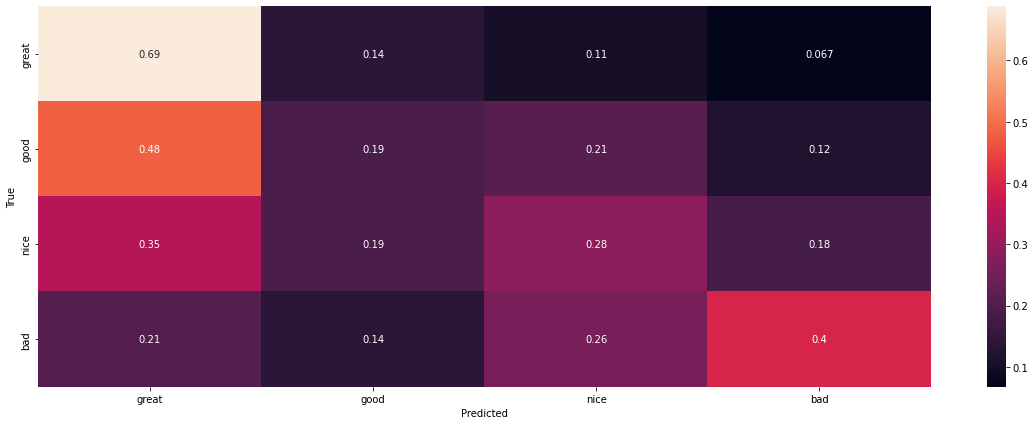

In [ ]:
# print(classification_report(valid_labels, y_pred))
valid_labels = np.array(targets)
y_pred = np.array(outputs)
plot_confusion_matrix(valid_labels, y_pred, label_names)

wrong_guesses = np.where(valid_labels != y_pred)
print(metrics.classification_report(targets, outputs))

In [ ]:
wrong_guesses[0][1]

2

In [ ]:
wrong_guesses[:10]

array([ 1,  2,  3,  4,  6,  8,  9, 11, 12, 13])

In [ ]:
np.unique(valid_labels)

array([0, 1, 2, 3])

In [ ]:
np.bincount(y_pred)

array([51101, 19418, 25347, 22852])

In [ ]:

print(categories[int(y_pred[int(wrong_guesses[0][0])])])
clean_dataset_test[int(wrong_guesses[0][0])]

good


{'title': 'SQL (oracle) Update some records in table using values in another table',
 'body': "<p>I have to tables :</p>\n\n<pre><code>Table1\n--------------------------------\nID         VAL1       DATE1\n--------------------------------\n1          1          20/03/2015\n2          null       null\n3          1          10/01/2015\n4          0          12/02/2015\n5          null       null\n\nTable2\n--------------------------------\nID         VAL2       DATE1\n--------------------------------\n1          N          02/06/2015\n1          N          01/08/2015\n2          null       null\n3          O          05/04/2016\n3          O          02/02/2015\n4          O          01/07/2015\n5          O          03/02/2015\n5          N          10/01/2014\n5          O          12/04/2015\n</code></pre>\n\n<p>I want to update :</p>\n\n<ul>\n<li>column VAL1 (of Table1) with '0', if VAL2 (of Table2) is equal to 'O'</li>\n<li>column DATE1 (of Table1) with the earliest DATE2 (of Table2

In [ ]:
correct_guesses = np.where(valid_labels == y_pred)

In [ ]:
print(categories[int(y_pred[int(correct_guesses[0][0])])])
clean_dataset_test[int(correct_guesses[0][0])]

great


{'title': 'Difference between grant_type=client_credentials and grant_type=password in Authentication Flow?',
 'body': '<p>I would like to understand the difference between <code>grant_type=client_credentials</code> and <code>grant_type=password</code> in <code>Authentication</code> or in <code>OAuth2 Flow</code> concept.</p>\n<p>I am following below sites:</p>\n<ul>\n<li><a href="http://help.atavist.com/api:authentication" rel="nofollow noreferrer">http://help.atavist.com/api:authentication</a></li>\n<li><a href="http://apiwiki.poken.com/authentication/oauth2" rel="nofollow noreferrer">http://apiwiki.poken.com/authentication/oauth2</a></li>\n</ul>\n<p>I presume <code>grant_type=password</code> is <code>not secure</code> way as far as using <code>grant_type</code> in JavaScript development. But I still wonder if someone can help me to understand this concept.</p>\n<p>I also observed that <code>grant_type=client_credentials</code> doesn\'t provide &quot;<code>refresh_token</code>&quot;,

In [ ]:
!mkdir drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/objects/t5_base_stackoverflow_quality_2

In [ ]:
with open('drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/objects/t5_base_stackoverflow_quality_2/correct_guesses.npy', 'wb') as f:
  np.save(f, correct_guesses)
  

In [ ]:
with open('drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/objects/t5_base_stackoverflow_quality_2/wrong_guesses.npy', 'wb') as f:
  np.save(f, wrong_guesses)

In [ ]:
clean_dataset_test.save_to_disk('drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/objects/t5_base_stackoverflow_quality_2/clean_dataset_test')